In [180]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [228]:
# ============================
# Optimized Parameters
# ============================
N = 3
meas_strength = 1     # Γₘ = 1
gamma = 1.25e-3 * meas_strength    # bit-flip rates γ_q = 1.25e-3 × Γₘ
# gamma = 0

t_op = 500
num_steps = 1000  # more steps for finer resolution
times = np.linspace(0, t_op, num_steps)
omega_max = 0.1 * meas_strength
sigma = 50
ntraj = 100


epsilon1 = -0.54
epsilon2 = 0.8

# Derived values
dt = times[1] - times[0]
tau = 2.5 / meas_strength
alpha = dt / (tau + dt)

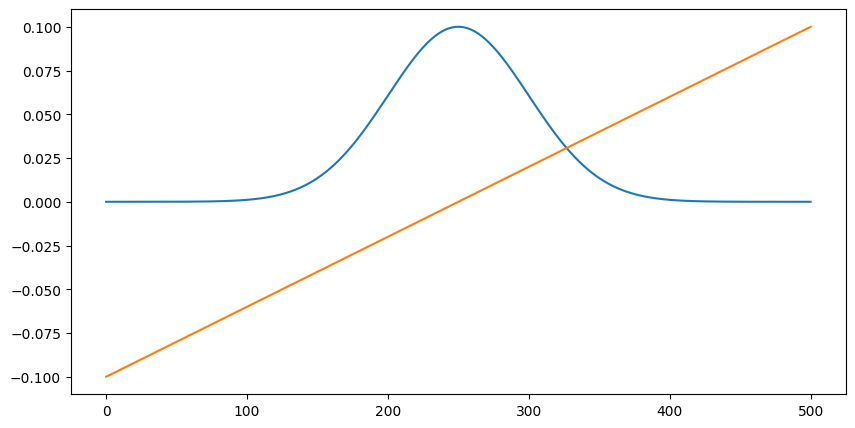

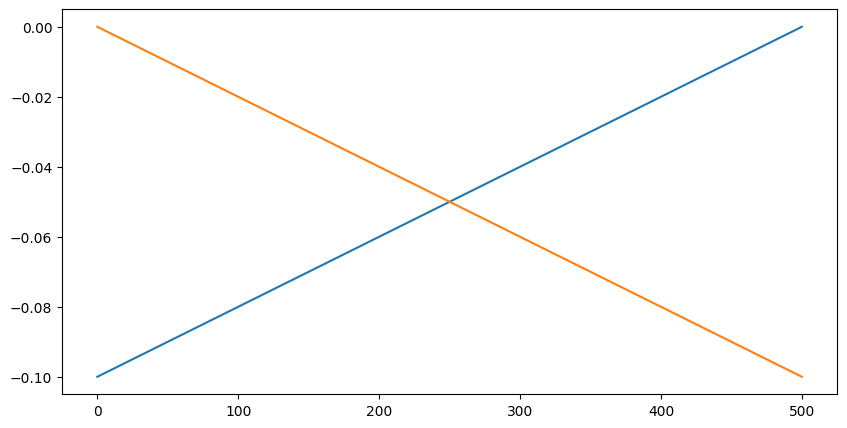

In [229]:
plt.figure(figsize=(10,5))

omega_t_p = lambda t: omega_max * np.exp(-0.5 * ((t - t_op / 2) / sigma) ** 2)
delta_t_p = lambda t: omega_max * (t / (t_op / 2) - 1)

plt.plot(times, omega_t_p(times))
plt.plot(times, delta_t_p(times))
plt.show()

plt.figure(figsize=(10,5))
a = lambda t: -omega_max * (1 - t / t_op)
b = lambda t: -omega_max * (t / t_op)

plt.plot(times, a(times))
plt.plot(times, b(times))
plt.show()

In [230]:
# ============================
# Operators
# ============================
Z = sigmaz()
X = sigmax()
I = qeye(2)

Z1Z2 = tensor(Z, Z, I)
Z2Z3 = tensor(I, Z, Z)

X1 = tensor(X, I, I)
X2 = tensor(I, X, I)
X3 = tensor(I, I, X)

X_ops = [X1, X2, X3]
X_L = tensor(X, X, X)
Z_L = (tensor(Z, I, I) + tensor(I, Z, I) + tensor(I, I, Z)) / 3

In [231]:
# Collapse and measurement operators
c_ops = [gamma * X_ops[i] for i in range(N)]
sc_ops = [np.sqrt(meas_strength) * Z1Z2, np.sqrt(meas_strength) * Z2Z3]

# Time-dependent Hamiltonian
def H_t(t, args):
    # a = 1 - t / t_op
    # b = t / t_op
    # return -omega_max * (a * X_L + b * Z_L)
    omega_t = omega_max * np.exp(-0.5 * ((t - t_op / 2) / sigma) ** 2)
    delta_t = omega_max * (t / (t_op / 2) - 1)
    return omega_t * X_L + delta_t * Z_L

# Initial state
psi0 = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
rho0 = psi0 * psi0.dag()

# ============================
# Run smesolve
# ============================
result = smesolve(H_t, rho0, times,
                     c_ops=c_ops,
                     sc_ops=sc_ops,
                     e_ops=[Z1Z2, Z2Z3],
                     ntraj=ntraj,
                     store_measurement=True,
                     options={'store_states': True})

10.0%. Run time: 361.89s. Est. time left: 00:00:54:16
20.0%. Run time: 771.55s. Est. time left: 00:00:51:26
30.0%. Run time: 1168.74s. Est. time left: 00:00:45:27
40.0%. Run time: 1566.22s. Est. time left: 00:00:39:09
50.0%. Run time: 1979.22s. Est. time left: 00:00:32:59
60.0%. Run time: 2417.09s. Est. time left: 00:00:26:51
70.0%. Run time: 2842.44s. Est. time left: 00:00:20:18
80.0%. Run time: 3256.08s. Est. time left: 00:00:13:34
90.0%. Run time: 3720.55s. Est. time left: 00:00:06:53
100.0%. Run time: 4112.24s. Est. time left: 00:00:00:00
Total run time: 4151.09s


In [219]:
# ============================
# EMA (Exponential Moving Average)
# similar to LPF 
# ============================
def ema(signal, alpha):
    filtered = np.zeros_like(signal)
    filtered[0] = signal[0]
    for i in range(1, len(signal)):
        filtered[i] = alpha * signal[i] + (1 - alpha) * filtered[i - 1]
    return filtered

def rc_low_pass_filter(signal, tau, dt):
    filtered = np.zeros_like(signal)
    filtered[0] = signal[0]
    alpha = dt / tau
    for i in range(1, len(signal)):
        filtered[i] = filtered[i-1] + alpha * (signal[i] - filtered[i-1])
    return filtered


# Match measurement length with time
min_len = min(len(result.measurement[0][0]), len(times))
I1_raw = np.mean([traj[:min_len] for traj in result.measurement[0]], axis=0)
I2_raw = np.mean([traj[:min_len] for traj in result.measurement[1]], axis=0)
times = times[:min_len]

# Apply filtering
I1_filt = ema(I1_raw, alpha)
I2_filt = ema(I2_raw, alpha)

# I1_filt = rc_low_pass_filter(I1_raw, tau, dt)
# I2_filt = rc_low_pass_filter(I2_raw, tau, dt)


# ============================
# Double-threshold diagnosis logic with reset
# ============================
reset_times = []
diagnosed_errors = []

for i in range(1, len(times)):
    i1 = I1_filt[i]
    i2 = I2_filt[i]

    if i1 > epsilon2 and i2 > epsilon2:
        continue  # no error

    # elif i1 < epsilon1 and i2 > epsilon2:
    #     diagnosed_errors.append(("X1", times[i]))
    #     I1_filt[i] = 1.0
    #     I2_filt[i] = 1.0
    #     reset_times.append(times[i])

    elif i1 < epsilon1 and i2 < epsilon1:
        diagnosed_errors.append(("X2", times[i]))
        I1_filt[i] = 1.0
        I2_filt[i] = 1.0
        reset_times.append(times[i])

    # elif i1 > epsilon2 and i2 < epsilon1:
    #     diagnosed_errors.append(("X3", times[i]))
    #     I1_filt[i] = 1.0
    #     I2_filt[i] = 1.0
    #     reset_times.append(times[i])


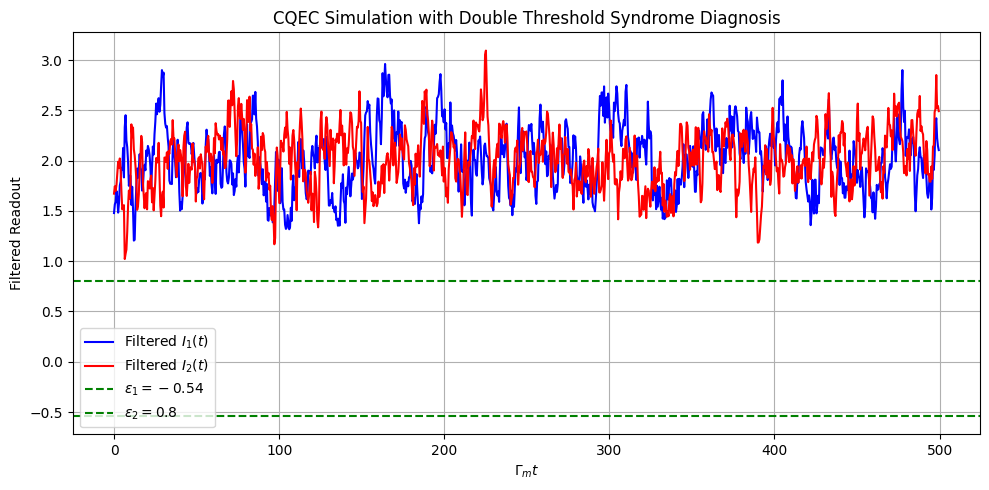

In [221]:
# ============================
# Plot like Fig. 1
# ============================
plt.figure(figsize=(10, 5))
plt.plot(times*meas_strength, I1_filt, label='Filtered $I_1(t)$', color='blue')
plt.plot(times*meas_strength, I2_filt, label='Filtered $I_2(t)$', color='red')
plt.axhline(epsilon1, color='green', linestyle='--', label=r'$\epsilon_1 = -0.54$')
plt.axhline(epsilon2, color='green', linestyle='--', label=r'$\epsilon_2 = 0.8$')

for rt in reset_times:
    plt.axvline(rt, color='black', linestyle=':', label='Reset' if rt == reset_times[0] else None)

# plt.xlim(0.5, 1)
# plt.ylim(-2, 2)
plt.xlabel(r"$\Gamma_m t$")
plt.ylabel("Filtered Readout")
plt.title("CQEC Simulation with Double Threshold Syndrome Diagnosis")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

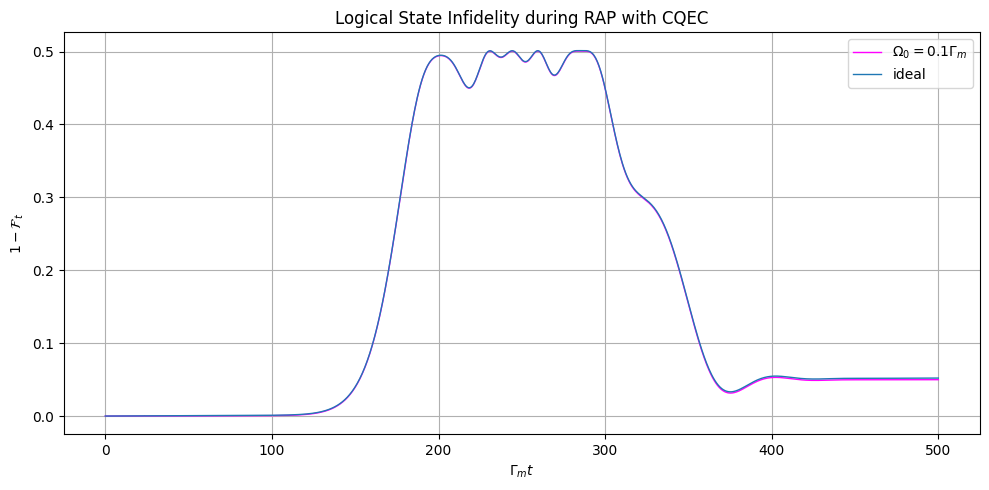

In [242]:
# ============================
# Ideal evolution (no noise)
# ============================
# Logical basis in 2D code space
zero_L = tensor(basis(2, 0), basis(2, 0), basis(2, 0))
one_L  = tensor(basis(2, 1), basis(2, 1), basis(2, 1))
proj_0 = zero_L * zero_L.dag()
proj_1 = one_L * one_L.dag()

# Logical Pauli operators in full 3-qubit space
X_L = tensor(sigmax(), sigmax(), sigmax())
Z_L = (tensor(sigmaz(), qeye(2), qeye(2)) +
       tensor(qeye(2), sigmaz(), qeye(2)) +
       tensor(qeye(2), qeye(2), sigmaz())) / 3


# Simulate ideal evolution (mesolve without noise)
result_ideal = mesolve(H_t, zero_L * zero_L.dag(), times, c_ops=c_ops,)

# ============================
# Fidelity vs ideal logical state
# ============================
fidelity_logical = []
fidelity_ideal = []

for i in range(len(times)):
    rho = result.states[i]  # assuming single trajectory or average
    rho_ideal = result_ideal.states[i]
    
    psi_ideal = rho_ideal.ptrace(0).eigenstates()[1][0]
    
    rho_proj = proj_0 * rho * proj_0 + proj_1 * rho * proj_1  # project to code space
    rho_ideal_proj = proj_0 * rho_ideal * proj_0 + proj_1 * rho_ideal * proj_1  # project to code space
    
    # fidelity_i = abs((psi_ideal.dag() * rho_ideal_proj * psi_ideal))  # ⟨ψ|ρ|ψ⟩
    # fidelity = abs((psi_ideal.dag() * rho_proj * psi_ideal))  # ⟨ψ|ρ|ψ⟩
    
    sqrt_rho = rho_ideal.sqrtm()

    fidelity_i = ((sqrt_rho * rho_ideal_proj * sqrt_rho).sqrtm().tr().real)**2    
    fidelity = ((sqrt_rho * rho_proj * sqrt_rho).sqrtm().tr().real)**2
    
    fidelity_logical.append(fidelity)
    fidelity_ideal.append(fidelity_i)

infidelity_logical = 1 - np.array(fidelity_logical)
infidelity_ideal = 1 - np.array(fidelity_ideal)

# ============================
# Plot: 1 - F(t) vs t Γm
# ============================
plt.figure(figsize=(10, 5))
plt.plot(times * meas_strength, infidelity_logical, label=r"$\Omega_0 = 0.1\Gamma_m$", color='magenta', linewidth=2)
plt.plot(times * meas_strength, infidelity_ideal, label=r"ideal", linewidth=2)

plt.xlabel(r"$\Gamma_m t$")
plt.ylabel(r"$1 - \mathcal{F}_t$")
plt.title("Logical State Infidelity during RAP with CQEC")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()